In [1]:
import pandas as pd
import numpy as np
import os, glob
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm, ticker
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

def getinfo(place, year):
    df = pd.read_csv('../DataBase/Experiment_period.txt')
    df_ = df[df['region']==place][df['year']==year]
    begintime = pd.to_datetime(df_['begin'].values[0])
    endtime = pd.to_datetime(df_['end'].values[-1])
    # month = str(begintime.month).zfill(2)
    return begintime, endtime

In [49]:
{str(year)[2:4]}

{'22'}

In [52]:
place = 'Keelung'
year = 2022
path = f'/Volumes/home/Research/Detection_snap/{place}/{str(year)[2:3]}?????-{str(year)[2:3]}?????'


savefig = True


if place == 'Taoyuan':
    begintime, endtime = getinfo(place, year)
    sunpath = glob.glob(f'../DataBase/Data_CWA/sunset_time_taoyuan{year}.csv')[0]
    lightpath = f'../DataBase/Temperature/Taoyuan/{str(year)[2:4]}*.xlsx'
    rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/467050_新屋/467050_{year}.csv')[0]
    tidepath = glob.glob(f'../DataBase/Data_cwa/{year}_1116_竹圍_tide.csv')[0]
    temp_cwapath = glob.glob(f'../DataBase/Data_CWA/{year}_1116_竹圍_stemp.csv')[0]
    # begintime = datetime(year, 4, 10); endtime = datetime(year, 9, 3)
    # ymin= 0; ymax = 4500 #Taoyuan 04 
    ymin = 0; ymax=6000

elif place == 'Keelung':
    begintime, endtime = getinfo(place, year)
    sunpath = glob.glob(f'../DataBase/Data_CWA/sunset_time_keelung{year}.csv')[0]
    lightpath = f'../DataBase/Temperature/Keelung/{str(year)[2:4]}*.xlsx'
    if year == 2021:
        rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/466940_基隆/466940_{year}.csv')[0]
    else:
        rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/C0B050_八斗子/C0B050_{year}.csv')[0]
    tidepath = glob.glob(f'../DataBase/Data_CWA/{year}_12191_長潭里_tide.csv')[0]
    temp_cwapath = glob.glob(f'../DataBase/Data_CWA/{year}_12191_長潭里_stemp.csv')[0]
    # begintime = datetime(year, 4, 17, 12); endtime = datetime(year, 5, 3, 12)
    ymin=3000; ymax=17000



print(begintime, endtime)
print(f'sunpath:   {sunpath}')
print(f'lightpath: {lightpath}')
print(f'rainpath:  {rainpath}')
print(f'tidepath:  {tidepath}')
print(f'temppath:  {temp_cwapath}')
dsun = pd.read_csv(sunpath)

2022-04-23 00:00:00 2022-08-23 23:00:00
sunpath:   ../DataBase/Data_CWA/sunset_time_keelung2022.csv
lightpath: ../DataBase/Temperature/Keelung/22*.xlsx
rainpath:  /Volumes/Data/Rainfall_CWA/C0B050_八斗子/C0B050_2022.csv
tidepath:  ../DataBase/Data_CWA/2022_12191_長潭里_tide.csv
temppath:  ../DataBase/Data_CWA/2022_12191_長潭里_stemp.csv


In [55]:
def figure_base_setting(ax):
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    ax[0].set_xlim(datetime(2021,4,1) ,datetime(2021,10,1))
    ax[1].set_xlim(datetime(2022,4,1) ,datetime(2022,10,1))
    ax[2].set_xlim(datetime(2023,4,1) ,datetime(2023,10,1))

    ax[0].grid(axis='y', color='lightgrey')
    ax[1].grid(axis='y', color='lightgrey')
    ax[2].grid(axis='y', color='lightgrey')

    ax[0].yaxis.set_minor_locator(MultipleLocator(1000))
    ax[0].yaxis.set_major_locator(MultipleLocator(2000))
    
    ax[0].yaxis.set_ticks_position('both')
    ax[1].yaxis.set_ticks_position('both')
    ax[2].yaxis.set_ticks_position('both')

    ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[2].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%b"))


11976.65 10545.0 9066.35
12070.349999999999 10580.0 8456.65
11198.0 9706.0 8422.75
13297.0 10144.0 6877.85
15389.0 13101.0 10937.35
11779.0 10546.5 8847.0
7736.0 5575.0 3911.4
8950.349999999999 6757.5 5188.0
9310.05 7222.0 5890.95


Text(0, 0.5, 'Snap rate (min$^{-1}$)')

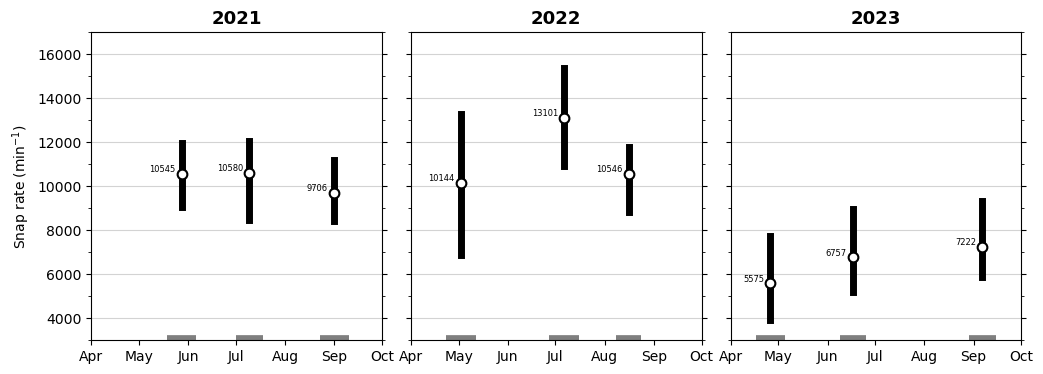

In [56]:
plt.rcParams["font.family"] = "DejaVu Sans"
fig, ax = plt.subplots(1,3,figsize=(12,4), sharey=True)
plt.subplots_adjust(wspace = 0.1) 

for dirpath in sorted(glob.glob(f'{path}')):
    alldf = pd.DataFrame()
    
    if '21' in dirpath:
        year = '2021'
        pidx = 0 
    elif '22' in dirpath:
        year = '2022'
        pidx = 1
    elif '23' in dirpath:
        year = '2023'
        pidx = 2
    ax[pidx].set_title(year, fontsize=13, fontweight='bold')
        
    timerange = dirpath.rsplit('/')[-1]
    begin = timerange.rsplit('-')[0]; end = timerange.rsplit('-')[1]
    begintime = datetime.strptime(begin, "%y%m%d")
    endtime = datetime.strptime(end, "%y%m%d")
    dt = endtime - begintime
    plottime = begintime + timedelta(days=dt.days/2)       
    
    for filepath in sorted(glob.glob(f'{dirpath}/*csv')):
        
        df = pd.read_csv(filepath)
        alldf = pd.concat([alldf, df])
        
    
    Q1 = np.percentile(alldf['Peak'], 95, interpolation='linear')
    Q2 = np.percentile(alldf['Peak'], 50, interpolation='linear')
    Q3 = np.percentile(alldf['Peak'], 5, interpolation='linear')
    
    
    print(Q1, Q2, Q3)
    ax[pidx].hlines(xmin=begintime, xmax=endtime, y=ymin-0.05, lw=7, color='black', alpha=0.5)
    ax[pidx].plot([plottime, plottime], [Q1, Q3], lw=5, color='black')
    ax[pidx].plot([plottime], [Q2], marker = 'o', markersize = 7, color='white', mec='k', mew=1.5)
    ax[pidx].text(plottime+timedelta(days=-4), Q2, int(Q2) , ha='right', va ='bottom', fontsize=6)
    
        # gettime = pd.to_datetime(df['Time'].values[0])
    
figure_base_setting(ax)
ax[0].set_ylim(ymin-10, ymax)
ax[0].set_ylabel('Snap rate (min$^{-1}$)')